In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np

## Preparing Dataset

In [2]:
def parse_data(sample):
    feature_description = {
        'image':tf.io.FixedLenFeature([], tf.string),
        'seg_map':tf.io.FixedLenFeature([], tf.string),
    }
    sample = tf.io.parse_single_example(sample, feature_description)
    sample['image'] = tf.io.decode_png(sample['image'],channels=1,dtype=tf.uint16)
    sample['seg_map'] = tf.io.decode_png(sample['seg_map'],channels=1)
    return sample


def prepare_data(sample):
    mri = tf.cast(sample['image'],dtype=tf.float16)
    mri = tf.image.resize(mri,size=(224,224))
    mri = mri / 255.0
    
    seg_map = tf.cast(sample['seg_map'],dtype=tf.uint8)
    seg_map = tf.image.resize(seg_map,size=(224,224))
    
    return mri, seg_map

# Datset paths
train = tf.io.gfile.glob('../datasets/Atrium-Segmentation/TF-Record/train/*')
valid = tf.io.gfile.glob('../datasets/Atrium-Segmentation/TF-Record/valid/*')
test = tf.io.gfile.glob('../datasets/Atrium-Segmentation/TF-Record/test/*')
len(train),len(valid),len(test)

(16, 2, 2)

In [3]:
def get_dataset(filenames, batch_size, train_test = 'train'):
    if train_test == 'train':
        dataset = (
            tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
            .map(parse_data, num_parallel_calls=tf.data.AUTOTUNE)
            .map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )
        
        return dataset
    
    elif train_test == 'valid':
        dataset = (
            tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
            .map(parse_data, num_parallel_calls=tf.data.AUTOTUNE)
            .map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )
        
        return dataset
    
    elif train_test == 'test':
        dataset = (
            tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
            .map(parse_data, num_parallel_calls=tf.data.AUTOTUNE)
            .map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )
        
        return dataset
    
# TF Datasets
train_data = get_dataset(train,batch_size=8,train_test='train')
valid_data = get_dataset(valid,batch_size=8,train_test='valid')
test_data = get_dataset(test,batch_size=8,train_test='test')

## 

## Model Definition 

### Encoder
<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet' width=500 height=400>

In [4]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    
    # Model Blocks of conv2d in UNET Encoder and Decoder
    conv_1 = tf.keras.layers.Conv2D(n_filters,kernel_size,padding='same',activation='relu')(input_tensor)
    conv_2 = tf.keras.layers.Conv2D(n_filters,kernel_size,padding='same',activation='relu')(conv_1)
    
    return conv_2

In [5]:
def encoder_block(input_tensor,n_filters=64,pool_size=(2,2)):
    """
    Two convolutional blocks and then perform down sampling on output of convolutions.
                                              (Using MaxPooling Layer)   
    """
    feature_maps = conv2d_block(input_tensor,n_filters=n_filters) # Skip Connection to the Decoder
    pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(feature_maps) # Passing down to the next encoder block
    
    return feature_maps,pooling_layer

def Encoder(input_tensor):
    """
    4 Encoder Blocks as showen above
    """
    features_1, pooling_1 = encoder_block(input_tensor, n_filters=64, pool_size=(2,2))
    features_2, pooling_2 = encoder_block(pooling_1, n_filters=128, pool_size=(2,2))
    features_3, pooling_3 = encoder_block(pooling_2, n_filters=256, pool_size=(2,2))
    features_4, pooling_4 = encoder_block(pooling_3, n_filters=512, pool_size=(2,2))
    
    # pooling_4 has shape 56 x 56 x 512
    return (features_1,features_2,features_3,features_4), pooling_4

def BottleNeck(input_tensor):
    '''
    This function defines the bottleneck convolutions to extract more features before the upsampling layers.
    '''
    # input_tensor == p4 from the encoder
    bottle_neck = conv2d_block(input_tensor, n_filters=2048)

    return bottle_neck    
    

### Decoder


<img src='https://drive.google.com/uc?export=view&id=1Ql5vdw6l88vxaHgk7VjcMc4vfyoWYx2w' alt='unet_decoder' width=500 height=500>

In [6]:
def decoder_block(input_tensors, skip_connections, n_filters=64, kernel_size = 3, strides = 3):
    """
    skip_connections
    """
    # Upsample Feature maps
    feature_maps = input_tensors
    upsampling = tf.keras.layers.Conv2DTranspose(filters=n_filters,kernel_size=kernel_size,
                                                strides=strides,padding='same')(input_tensors)
    
    concat = tf.keras.layers.concatenate([upsampling,skip_connections])
    # Extract New Features from concat layer
    concat_conv = conv2d_block(concat,n_filters)
    
    return concat_conv

def Decoder(input_tensors, encoder_convs,output_channels):
    
    features_1,features_2,features_3,features_4 = encoder_convs
    
    bottleneck = input_tensors
    
    concat_conv_4 = decoder_block(bottleneck, features_4, n_filters=512, kernel_size=(3,3), strides=(2,2))
    concat_conv_3 = decoder_block(concat_conv_4, features_3, n_filters=256, kernel_size=(3,3), strides=(2,2))
    concat_conv_2 = decoder_block(concat_conv_3, features_2, n_filters=128, kernel_size=(3,3), strides=(2,2))
    concat_conv_1 = decoder_block(concat_conv_2, features_1, n_filters=64, kernel_size=(3,3), strides=(2,2))
    
    # Only one class label
    outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='sigmoid')(concat_conv_1)
    
    return outputs

## UNET

In [7]:
OUTPUT_CHANNELS = 1 # as classes

def unet(input_shape):
    '''
    Defines the UNet by connecting the encoder, bottleneck and decoder.
    '''

    # specify the input shape
    inputs = tf.keras.layers.Input(shape=input_shape)

    # feed the inputs to the encoder
    # (features_1,features_2,features_3,features_4), pooling_4 from Encoder
    feature_maps, maxpooling_output  = Encoder(inputs)

    # feed the encoder output to the bottleneck
    bottle_neck = BottleNeck(maxpooling_output)

    # feed the bottleneck and encoder block outputs to the decoder
    # specify the number of classes via the `output_channels` argument
    outputs = Decoder(bottle_neck, feature_maps, output_channels=OUTPUT_CHANNELS)

    # create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# instantiate the model
input_shape = [224,224,1] # [128,128,1]
model = unet(input_shape)

# see the resulting model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

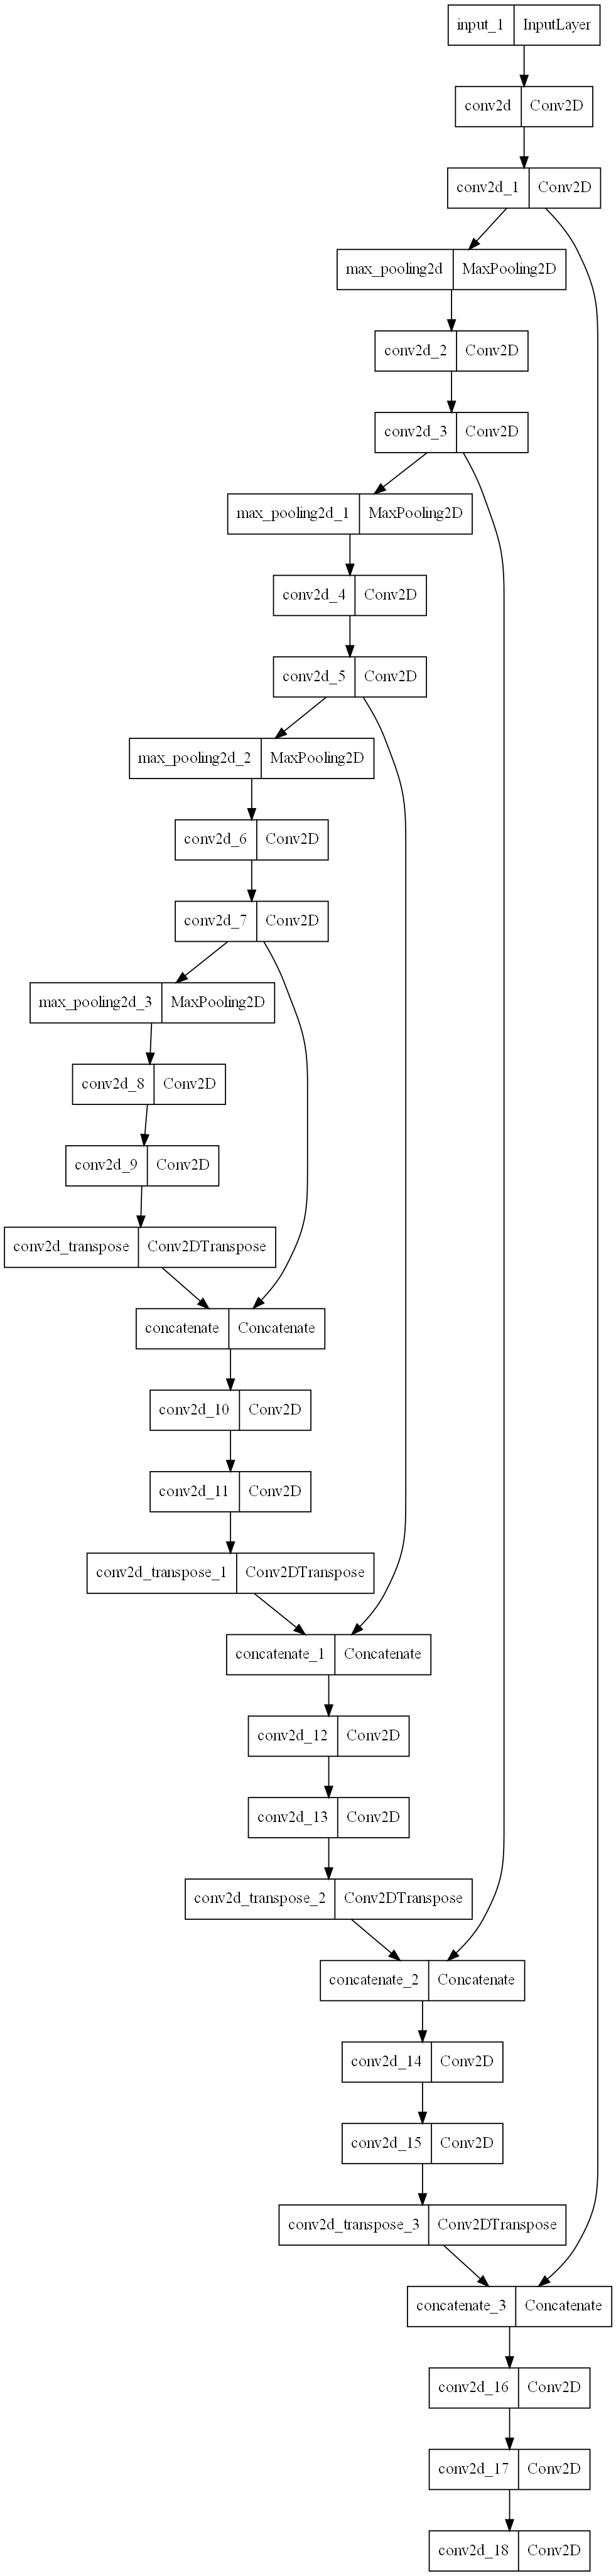

In [8]:
tf.keras.utils.plot_model(model,dpi=128)

## 

## Training

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=10,restore_best_weights=True)

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# # number of training images
# train_count = 1816 # 227 * 8 - 4

# # number of validation images
# validation_count = 240 # 30 * 8

EPOCHS = 100
# BATCH_SIZE = 8

# steps_per_epoch = train_count//BATCH_SIZE
# validation_steps = validation_count//BATCH_SIZE

history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=EPOCHS,callbacks=[es])

Epoch 1/100
227/227 [==============================] - 78s 303ms/step - loss: 14.2436 - accuracy: 0.9901 - val_loss: 0.7599 - val_accuracy: 0.9930
Epoch 2/100
227/227 [==============================] - 63s 279ms/step - loss: 0.0118 - accuracy: 0.9949 - val_loss: 0.1942 - val_accuracy: 0.9943
Epoch 3/100
227/227 [==============================] - 63s 280ms/step - loss: 0.0097 - accuracy: 0.9957 - val_loss: 0.1207 - val_accuracy: 0.9933
Epoch 4/100
227/227 [==============================] - 64s 281ms/step - loss: 0.0092 - accuracy: 0.9959 - val_loss: 0.0569 - val_accuracy: 0.9921
Epoch 5/100
227/227 [==============================] - 64s 281ms/step - loss: 0.0085 - accuracy: 0.9961 - val_loss: 0.0668 - val_accuracy: 0.9947
Epoch 6/100
227/227 [==============================] - 64s 284ms/step - loss: 0.0073 - accuracy: 0.9965 - val_loss: 0.0396 - val_accuracy: 0.9945
Epoch 7/100
227/227 [==============================] - 64s 281ms/step - loss: 0.0065 - accuracy: 0.9969 - val_loss: 0.1612 

## 

## Evaluation 

In [11]:
import pandas as pd

<AxesSubplot:>

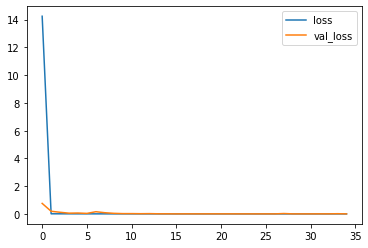

In [12]:
losses = pd.DataFrame(history.history)
losses[['loss','val_loss']].plot()

<AxesSubplot:>

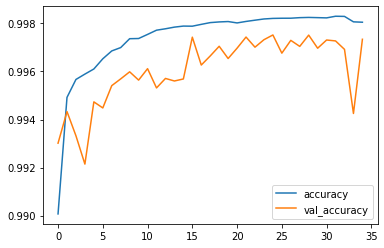

In [13]:
losses[['accuracy','val_accuracy']].plot()

#### Prediction GIF

In [14]:
from celluloid import Camera 

In [15]:
valid_dataset = tf.data.TFRecordDataset(valid[0])
valid_dataset = valid_dataset.map(parse_data).map(prepare_data).batch(8)

In [16]:
preds = model.predict(valid_dataset)
print(preds.shape)
threshold = 0.3
results = np.where(preds > threshold,1,0)
print(results.shape)

(120, 224, 224, 1)
(120, 224, 224, 1)


MovieWriter ffmpeg unavailable; using Pillow instead.


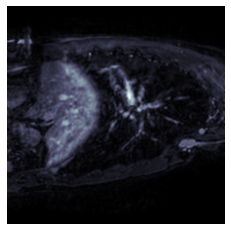

In [17]:
raw_dataset = tf.data.TFRecordDataset(valid[0])
parsed_dataset = raw_dataset.map(parse_data).map(prepare_data)

fig = plt.figure()
camera_test = Camera(fig)
for data,pred in zip(parsed_dataset,results):
    mri, seg_map = data
#     print(pred.shape)

    plt.imshow(mri,cmap='bone')
#     plt.show()
    
    # mask array where 
    pred_label = np.ma.masked_where(pred == 0,pred)
    plt.imshow(pred_label, alpha=0.5, cmap="autumn")
    plt.axis('off')
    camera_test.snap()
    
animation = camera_test.animate()
animation.save('pred_UNET_tf_artium.gif',fps=60)     